# Least squares

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys
sys.path.insert(0,'../')

In [2]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.optimize import lsq_linear

from system_identification.lsqr_model import LeastSquaresModel

# 1D

In [3]:
def foo(x):
    return 0.8 * np.tanh(x * 0.4 - 0.7) + 2.1

# def foo(x):
#     return 0.01 * x**2

input_range = [[-5, 10]]
inputs = np.linspace(*input_range[0], 10000)
reference_outputs = np.array(list(map(foo, inputs)))
reference_outputs_noisy = reference_outputs + np.random.normal(0, 0.1, size=reference_outputs.shape)

inputs = inputs.reshape(-1, 1, 1)
reference_outputs = reference_outputs.reshape(-1, 1, 1)
reference_outputs_noisy = reference_outputs_noisy.reshape(-1, 1, 1)

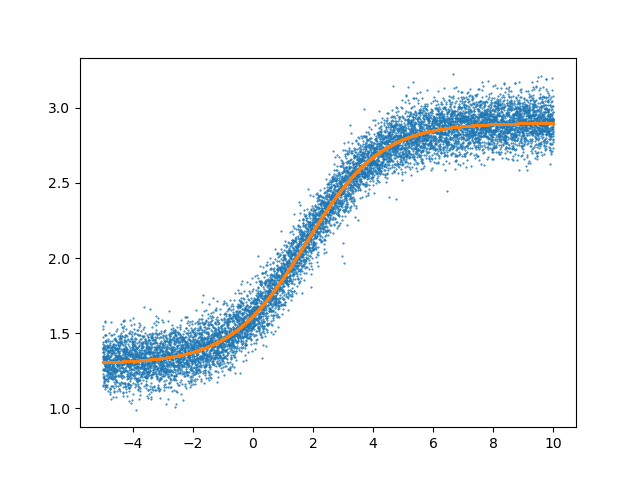

In [4]:
plt.figure()
plt.plot(inputs[:, 0, 0], reference_outputs_noisy[:, 0, 0], ".", markersize=1)
plt.plot(inputs[:, 0, 0], reference_outputs[:, 0, 0], ".", markersize=1)

In [5]:
model = LeastSquaresModel.new_polynomial(
    n_inputs=1,
    input_range=input_range,
    order=3)
model

In [6]:
type(model.func(0))

list

In [7]:
model.train(inputs, reference_outputs_noisy)

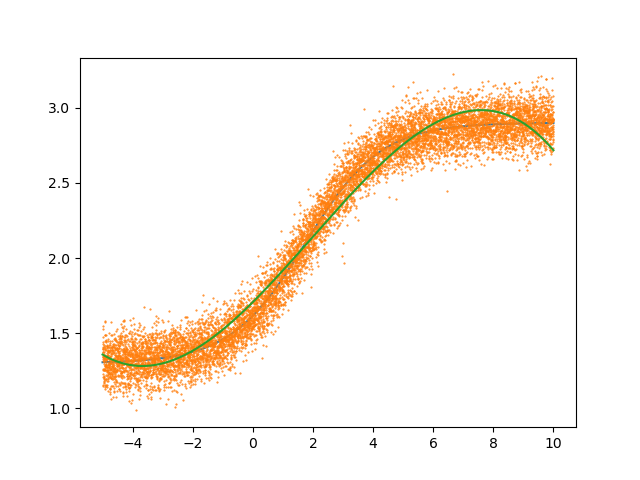

In [8]:
fig = plt.figure()
outputs = model.evaluate(inputs)
plt.plot(inputs.squeeze(), reference_outputs.squeeze())
plt.plot(inputs.squeeze(), reference_outputs_noisy.squeeze(), ".", markersize=1)
plt.plot(inputs.squeeze(), outputs.squeeze())

In [9]:
model.training_log

<xarray.Dataset>
Dimensions:                (epoch: 1, i: 10000, j: 1, k: 4)
Coordinates:
  * epoch                  (epoch) int64 1
Dimensions without coordinates: i, j, k
Data variables: (12/14)
    gradient               (epoch) float64 nan
    error_training_data    (epoch, i) float64 0.0862 -0.09609 ... 0.2097 0.05658
    error_validation_data  (epoch, j) float64 nan
    error_training_jb      (epoch) float64 6.486
    error_training_jbp     (epoch) float64 0.03904
    error_training_skew    (epoch) float64 0.0454
    ...                     ...
    error_validation_jbp   (epoch) float64 nan
    error_validation_skew  (epoch) float64 nan
    error_validation_kurt  (epoch) float64 nan
    coefficients           (epoch, k) float64 1.707 0.1992 0.01398 -0.00238
    min_residual_epoch     float64 nan
    min_jb_epoch           float64 nan

  0%|          | 0/24 [00:00<?, ?it/s]

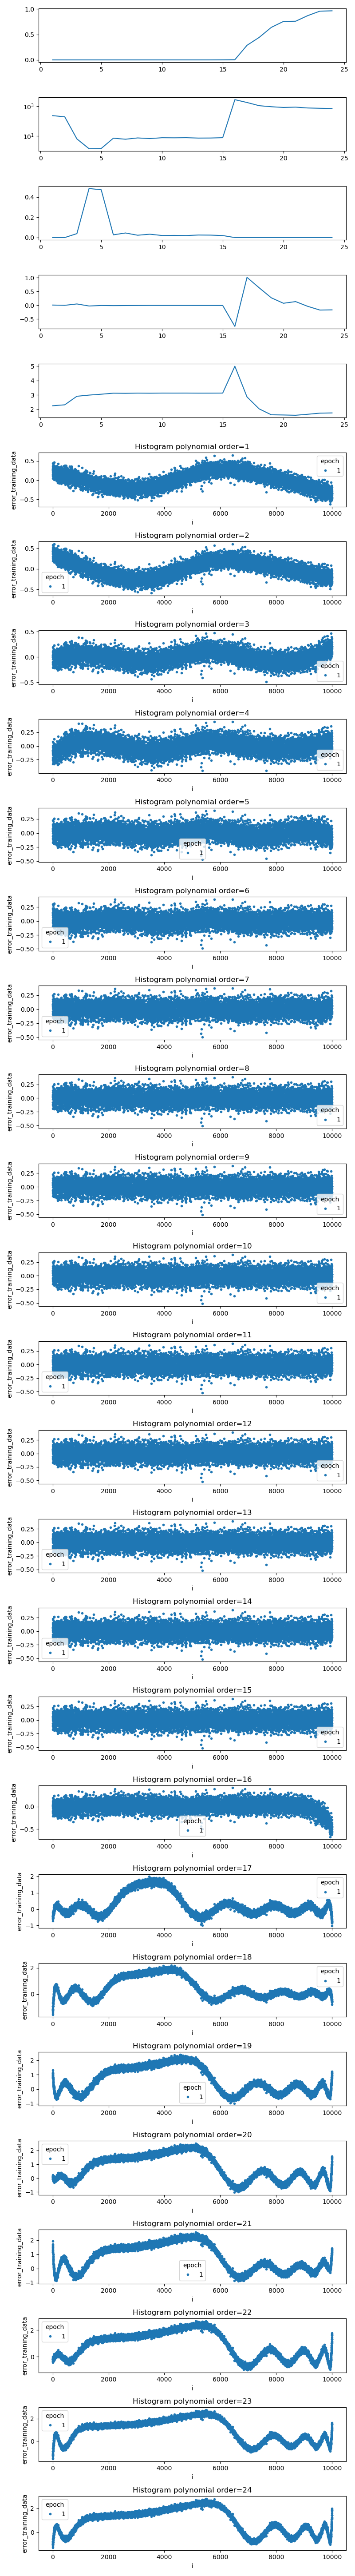

In [10]:
orders = list(range(1, 25))
extra_axis = 5
fig, axs = plt.subplots(len(orders) + extra_axis, 1, figsize=(8, (len(orders) + extra_axis) * 2))

error_mean = []
error_jb = []
error_jbp = []
error_skew = []
error_kurt = []

for i, order in tqdm(enumerate(orders), total=len(orders)):
    model = LeastSquaresModel.new_polynomial(
        n_inputs=1,
        input_range=input_range,
        order=order)

    model.train(inputs, reference_outputs_noisy)

    error_mean.append(model.training_log.error_training_data.mean())

    error_jb.append(model.training_log.error_training_jb.item())
    error_jbp.append(model.training_log.error_training_jbp.item())
    error_skew.append(model.training_log.error_training_skew.item())
    error_kurt.append(model.training_log.error_training_kurt.item())

    model.training_log.error_training_data.plot.line(x='i', ls=" ", marker=".", ax=axs[i+extra_axis])
    axs[i+extra_axis].set_title(f"Histogram polynomial order={order}")

axs[0].plot(orders, error_mean)
axs[1].plot(orders, error_jb)
axs[2].plot(orders, error_jbp)
axs[3].plot(orders, error_skew)
axs[4].plot(orders, error_kurt)

axs[1].set_yscale('log')

plt.tight_layout()

## 2D

In [11]:
input_range = np.array([(-1, 1), (-3, 5)])


def foo(x):
    return -x[0]**2 + np.tanh(x[1]*2)


resolution = 100
inputs = np.array(tuple(product(np.linspace(*input_range[0, :], resolution),
                                np.linspace(*input_range[1, :], resolution))))

reference_outputs = np.array(list(map(foo, inputs)))
reference_outputs_noisy = reference_outputs + (np.random.random(reference_outputs.shape) - 0.5) * 0.1

inputs = inputs[..., None]
reference_outputs = reference_outputs.reshape(-1, 1, 1)
reference_outputs_noisy = reference_outputs_noisy.reshape(-1, 1, 1)

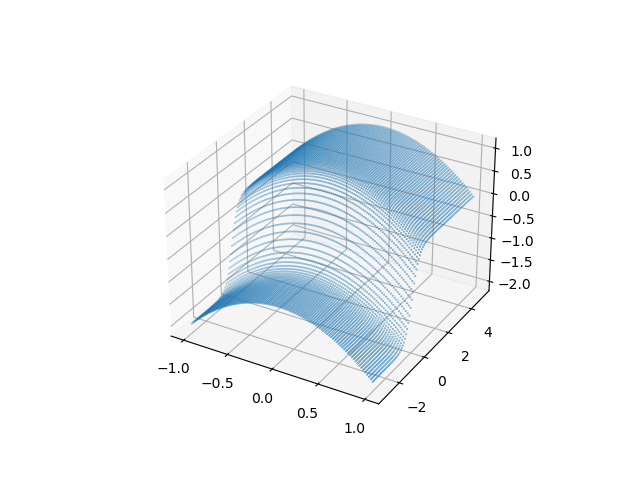

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(inputs[:, 0, 0], inputs[:, 1, 0], reference_outputs.squeeze(), s=0.1)

In [13]:
model = LeastSquaresModel.new_polynomial(
    n_inputs=2,
    input_range=input_range,
    order=5)
model

In [14]:
model.train(inputs, reference_outputs)

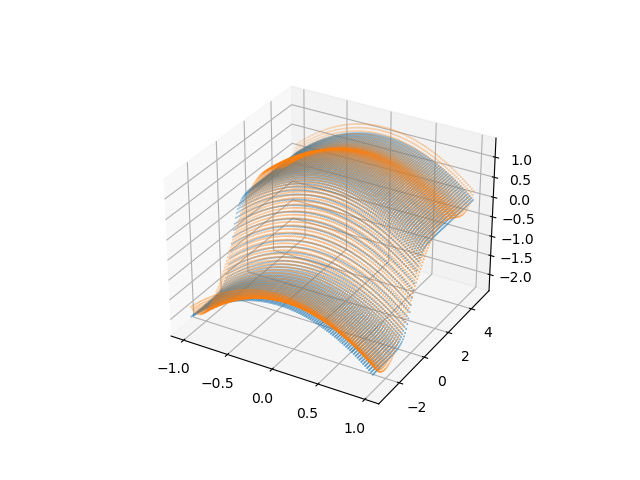

In [15]:
fig = plt.figure()
output = model.evaluate(inputs)
ax = fig.add_subplot(projection='3d')
ax.scatter(inputs[:, 0, 0], inputs[:, 1, 0], reference_outputs.squeeze(), s=0.1)
ax.scatter(inputs[:, 0, 0], inputs[:, 1, 0], output.squeeze(), s=0.1)